# Kaggle - G-Research Crypto Forecasting | Model Fitting

## Time Constraints
I will often take shortcuts due to the time constraints I have. A lot of ideas from the `init.ipynb` notebook do not make it here, and the testing I do here should be more careful. For the purposes of this Kaggle Competition however I am *okay* with this - as long as I have explored some interesting ideas I will be happy.

## Clustering
From the data exploration notebook, we found the clusters:
- Dogecoin, IOTA, Maker, Monero (4, 8, 10, 11)
- Ethereum Classic (7)
- Binance Coin, Cardano, Stellar (0, 3, 12)
- Bitcoin Cash, EOS.IO, TRON (2, 5, 13)
- Bitcoin, Ethereum, Litecoin (1, 6, 9)

... move 7 in the group (0, 3, 12) since these *are* somewhat correlated and since we want pooled models for all assets.

In [1]:
clusters = {
    0: (4, 8, 10, 11),
    2: (0, 3, 12, 7), # move 7 in this cluster
    3: (2, 5, 13),
    4: (1, 6, 9),
} # arbitrary cluster labels

## Time Reversal
Viewing price evolution as a physical process we would expect it to have time symmetry (the same process can happen backwards in time).

This (almost) doubles the amount of data we have - if there are patterns with time reversal symmetries then training with normal + reversed data should give better models.

## Training approaches
### Setup
We will train single asset, pooled and panel models for each cluster using normal + time reversed data (either separately or together)- this gives at most 6 different models for any single asset. We expect that these different training approaches will work better in combination than a single asset model - this will explicitly be checked.

### Models
We focus on tree models for simplicity. I expect explicit sequence models (eg LSTM) will also be useful, however I expect we'll run into memory issues if we're not careful with data processing, so we don't explore these.

In [4]:
! conda update scikit-learn -y

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - scikit-learn


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    anyio-3.4.0                |   py37h89c1867_0         149 KB  conda-forge
    black-21.12b0              |     pyhd8ed1ab_0         122 KB  conda-forge
    brotli-1.0.9               |       h7f98852_6          18 KB  conda-forge
    brotli-bin-1.0.9           |       h7f98852_6          19 KB  conda-forge
    brotlipy-0.7.0             |py37h5e8e339_1003         342 KB  conda-forge
    chardet-4.0.0              |   py37h89c1867_2         199 KB  conda-forge
    charset-normalizer-2.0.9   |     pyhd8ed1ab_0          34 KB  conda-forge
    conda-package-handling-1.7.3|   py37h5e8e339_1        1008 KB  conda-forge
    confuse-1.7.0              |     pyhd8ed1ab_0          24 KB  conda-forge
    cryptography-36.0.1 

In [4]:
! pip install -e lib/

Obtaining file:///home/lib
  Preparing metadata (setup.py) ... done
  Running setup.py develop for foo


In [2]:
import pickle
from functools import partial

import lightgbm
import numpy as np
import pandas as pd
import cvxpy as cp

from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler


from lib.data_utils import *
from lib.features import *
from lib.metrics import *
from lib.models import *
from lib.transformations import *
from lib.utils import *
from lib.cross_validation import *

ad = pd.read_csv("asset_details.csv").set_index("Asset_ID")
weights = ad["Weight"]
weights /= weights.sum()

%load_ext autoreload
%autoreload 2

## Prepare Data

In [3]:
# all_features = all_feats(pd.read_csv("work/train.csv"), weights)

# with open("work/processed_data/all_features.pkl", "wb") as f:
#     pickle.dump(all_features, f)

with open("processed_data/all_features.pkl", "rb") as f:
    data = pickle.load(f)

## Train/Validation/Test split
Split into (roughly) 80/20 train/test splits and split the test set into a further validation set in the same ratio.

In [4]:
(train_ind, test_ind), = ts_split(data.index, 1, 0.2)
(train_ind, validation_ind), = ts_split(train_ind, 1, 0.2)

train = data.loc[train_ind]
train_stacked = train.stack()

target_weights = ad[["Weight"]].rename(columns={"Weight": "target_weight"})
train_stacked = train_stacked.join(target_weights, on="Asset_ID") # FIXME: this should be done in the library

In [5]:
cols = train.columns.get_level_values(0).unique()
features = [k for k in cols if "target" not in k]

## Baselines

### Single Asset Model
Look at models for Bitcoin (Asset_ID=1) for simplicity.

Note: we'll use the validation set after we've done some sanity checks/basic tests.

In [9]:
train_1 = train.loc[:, (slice(None), 1)].iloc[300:].dropna()
timestamps_1 = train_1.index

(base_train, base_test), = ts_split(timestamps_1, 1, 0.2)

In [42]:
base_model = Pipeline([("scale", StandardScaler()), ("regress", Lasso(alpha=1e-6))])

corr_func = lambda x, y: np.corrcoef(x, y)[0, 1]
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(base_model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

0.005085550830016444


... 0.5% correlation: we expect to do better than this with more complex models - I suspect underfitting since the model is simple (considering the data set size + # of features). Let's check the in sample correlation:

In [43]:
insample_corr = fit_model(base_model, base_train, base_train, train_1, eval_func)[1][1]
print(insample_corr)

0.013259342918220157


## Information Decay
Let's quickly check for any obvious information leakage. We intentionally leak/delay information to check the effect on the correlation.

The correlation increases drastically when we intentionally leak forward information and decreases (slightly) as we lag information - this is what we'd expect if there is no information leakage (and if we're using the latest information).

In [56]:
shifts = [-5, -1, 0, 1, 5]

shift_corrs = {}

for shift in shifts:
    train_1_copy = train_1.copy()
    train_1_copy.loc[:, features] = train_1_copy.loc[:, features].shift(shift, fill_value=0)
    corr = fit_model(base_model, base_train, base_train, train_1_copy, eval_func)[1][1]
    shift_corrs[shift] = corr
    
shift_corrs

{-5: 0.18992970400450615,
 -1: 0.09205940205206822,
 0: 0.013259342918220157,
 1: 0.01179552738747167,
 5: 0.006840268610342508}

### Increase Complexity

#### Trees
Let's try the same setup but using a tree-based model for more complexity. Use lgbm for its low compute times + resources (compared to XGBoost). Only change the default learning rate since (0.1) since I suspect it is too high.

We get a 1.5% correlation out of sample - better than the Lasso model's in sample correlation. This is consistent with Lasso underfitting.

In [57]:
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(tree_model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.015525694922673033


#### Neural Nets
Let's also try a more explicit regression via a NN model.

This gives random results due to the dropout layer (we do not seed this) - the result is positive most of the time with correlation >2% - this is better than the tree model above so let's consider this for the final model.

Due to (relatively) long training times for this NN, we mostly use tree models for testing. Add NN models back towards the end of the testing phase.

In [332]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        layers.Dense(10, activation="linear"), # correlated features so first linearly separate
        layers.Dense(8, activation="tanh"),
        layers.Dropout(0.01), # to help prevent overfitting
        layers.Dense(4, activation="tanh"),
        layers.Dropout(0.01),
        layers.Dense(2, activation="tanh"),
        layers.Dense(1, activation="tanh"),     # output is roughly normally distributed
        layers.Dense(1, activation="linear"),   # so match with tanh + linear scaling
    ]
)

model.compile(
    optimizer='Adam',
    loss='mse',
)

eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

31281/31281 [==============================] - 26s 815us/step - loss: 1.1241
0.026729958539541295


In [13]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6071783451182101385
]


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential(
    [
        layers.Dense(10, activation="linear"), # correlated features so first linearly separate
        layers.Dense(8, activation="tanh"),
        layers.Dropout(0.01), # to help prevent overfitting
        layers.Dense(4, activation="tanh"),
        layers.Dropout(0.01),
        layers.Dense(2, activation="tanh"),
        layers.Dense(1, activation="tanh"),     # output is roughly normally distributed
        layers.Dense(1, activation="linear"),   # so match with tanh + linear scaling
    ]
)

model.compile(
    optimizer='Adam',
    loss='mse',
)

eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

## Combining Models
Combining estimators could be helpful since Lasso and tree based models are quite different. Let's check this using a 90:10 weighting:

This isn't a significant improvement, but let's keep this in mind when considering robustness since we will generally prefer simpler models if the performance is the same to help prevent overfitting.

In [249]:
from sklearn.ensemble import VotingRegressor
model = VotingRegressor([("tree", tree_model), ("lasso", base_model)], weights=[0.9, 0.1])
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])

corr = fit_model(model, base_train, base_test, train_1, eval_func)[1][1]
print(corr)

/opt/conda/lib/python3.9/site-packages/sklearn/ensemble/_voting.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0155712606663362


## Observation Weighting
A hypothesis is that recent data is more relevant and hence should be weighted more - let's test this.

We generally do better with equal weighting - this could suggest we'd do better with more data. We can produce some synthetic data using the time reversal discussed earlier. Due to time + compute (memory) constraints we'll not do this.

<AxesSubplot:>

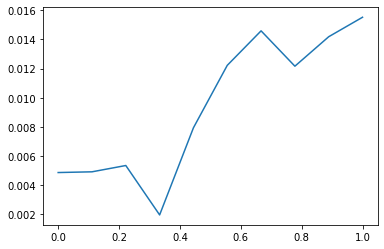

In [216]:
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=[1])
corrs = {}

for end_weight in np.linspace(0, 1, 10):
    weighting = linear_weighting(base_train, end_weight)
    corr = fit_model(tree_model, base_train, base_test, train_1, eval_func, sample_weight=weighting)[1][1]
    corrs[end_weight] = corr
pd.Series(corrs).plot()

## Panel Models
Let's run the same process, but for a panel model on the cluster 1, 6, 9.

We do slightly worse (1.1% correlation), but since the construction is different from the above we might still expect value in an ensemble

In [12]:
train_169 = train.loc[:, (slice(None), [1, 6, 9])].iloc[300:].fillna(0)

In [111]:
cluster_169 = [1, 6, 9]
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
panel_model = MultiOutputRegressor(tree_model, n_jobs=1)
eval_func = partial(evaluate_panel, metrics_func=corr_func, asset_labels=cluster_169)

panel_model, corrs = fit_model(panel_model, base_train, base_test, train_169, eval_func)
print(corrs)

{1: 0.011146811384561705, 6: 0.08807703583664798, 9: 0.0822467941222047}


## Panel Feature Importances
Let's check if this construction makes sense: the idea is that information about other assets is useful for asset 1. We can see this from the feature importances, eg `price_mom_80` for all assets are the highest ranked features.

Moreover we check this isn't trivially due to substitution effects since these features aren't highly correlated.

In [89]:
fi = panel_model.estimators_[0].feature_importances_
fi = fi / fi.sum()
pd.Series(dict(zip(train_169, fi))).sort_values(ascending=False).head(10)

price_mom_80     1    0.097667
                 6    0.089333
                 9    0.076333
obs_vol_roll_15  1    0.075000
price_mom_15     1    0.054000
                 9    0.052000
                 6    0.048000
obs_vol_roll_15  9    0.047000
price_mom_5      1    0.045000
obs_vol_roll_15  6    0.037333
dtype: float64

In [75]:
train_169.price_mom_80.corr() # low pairwise correlations

Asset_ID,1,6,9
Asset_ID,,,
1,1.000000,-0.029013,-0.017179
6,-0.029013,1.000000,0.033436
9,-0.017179,0.033436,1.000000


## Pool Models
Finally, let's rerun for the pooling setup.

This gives the best result - 5.2% correlation out of sample.

In [35]:
train_stacked_169 = train_stacked.loc[(slice(None), [1, 6, 9]), :].dropna()

In [151]:
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_pool, metrics_func=corr_func, asset_labels=cluster_169)

pool_model, corrs = fit_model(tree_model, base_train, base_test, train_stacked_169, eval_func)
print(corrs)

{1: 0.052941912578945836, 6: 0.0875750282120129, 9: 0.09565403822718907}


... let's see the results if fitting on __all__ assets. We do even better! I suspect this can be improved further by weighting the observations (high volume asset observations should be more highly weighted)

In [124]:
train_stacked_ = train_stacked.dropna()
all_assetsids = np.sort(ad.index.values)
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_pool, metrics_func=corr_func, asset_labels=all_assetsids)

pool_model, corrs = fit_model(tree_model, base_train, base_test, train_stacked_, eval_func)
print(corrs)

{0: 0.06323605623718401, 1: 0.06411559142909154, 2: 0.0385115163741001, 3: 0.06140599837031627, 4: 0.07589535023090965, 5: 0.10505801557330886, 6: 0.09068664881123362, 7: 0.03243507655574745, 8: 0.05236936638345779, 9: 0.11049336463456941, 10: -0.04691362246395552, 11: 0.014789574642226109, 12: 0.0610717908441916, 13: 0.08328190165377237}


... surprisingly little difference to the results. This could just be because we have more data for the highly weighted coins so the explicit weighting has little effect.

In [153]:
tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_pool, metrics_func=corr_func, asset_labels=all_assetsids)

panel_model, corrs = fit_model(
    tree_model, base_train, base_test, train_stacked_, eval_func, sample_weight=train_stacked_.loc[base_train].target_weight
    )
print(corrs)

{0: 0.06425686729545158, 1: 0.06074381736768591, 2: 0.036233133302478196, 3: 0.05850627375916052, 4: 0.07321166996649121, 5: 0.1024561072527459, 6: 0.08964857859382389, 7: 0.03368548726976016, 8: 0.043520049009335794, 9: 0.1106910564745762, 10: -0.03856261815716083, 11: 0.01104248732595526, 12: 0.05556102936455344, 13: 0.08117724257111841}


## Ensemble Models
All above approaches (single asset, panel, pool) are different, so we might expect averaging to give better results than individual predictions. Let's check this:

All predictions are somewhat correlated, but the panel model is highly correlated with the single asset model. For simplicity let's drop the panel model and focus on combining panel + single asset models.


FIXME: this is a bit messy. We are still researching things however, so acceptable for now, but let's make this cleaner when settling on a solution.

In [246]:
### pool
preds_func = lambda yt, yp: {"true": yt, "pred": yp}

tree_model = lightgbm.LGBMRegressor(learning_rate=0.04)
eval_func = partial(evaluate_pool, metrics_func=preds_func, asset_labels=all_assetsids)

_, pool_preds = fit_model(tree_model, base_train, base_test, train_stacked_, eval_func)

### panel
panel_model = MultiOutputRegressor(tree_model, n_jobs=1)
eval_func = partial(evaluate_panel, metrics_func=preds_func, asset_labels=cluster_169)

_, panel_preds = fit_model(panel_model, base_train, base_test, train_169, eval_func)

### single
eval_func = partial(evaluate_panel, metrics_func=preds_func, asset_labels=[1])

_, single_preds = fit_model(tree_model, base_train, base_test, train_1, eval_func)

all_preds = {
    "single": single_preds[1]["pred"],
    "pool": pool_preds[1]["pred"],
    "panel": panel_preds[1]["pred"],
    "true": single_preds[1]['true'],
    }
all_preds = pd.DataFrame(all_preds)
print(all_preds.corr())

          single      pool     panel      true
single  1.000000  0.188878  0.508199  0.015526
pool    0.188878  1.000000  0.139867  0.064116
panel   0.508199  0.139867  1.000000  0.011147
true    0.015526  0.064116  0.011147  1.000000


We have an optimum when combining pool + single predictions in a 95:5 ratio - since the pool model does much better than the single asset model we expect the pool model to have a higher weight.

<AxesSubplot:>

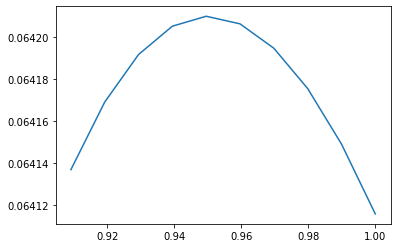

In [268]:
combined_preds = lambda t: all_preds["pool"] * t + all_preds["single"] * (1-t)
combined_corr = lambda t: combined_preds(t).corr(all_preds["true"])
combined_corrs = {t: combined_corr(t) for t in np.linspace(0, 1, 100)}

pd.Series(combined_corrs).loc[0.9:].plot() # plot a subset to show the optimum

# Final Models

## Panel and Single Asset Models
From the above results, we focus on combining panel + pool models. We write an sklearn model class `PoolRegressor` to make it easier to work with pooled + single asset models.

## Configuration
The setup for these models will be:
- Average `Lasso` + `NN` + `LGBM` models
- Average single asset and pool models

## Hyperparameter Tuning
So far we've not done any hyperparameter tuning for simplicity. Now we've decided our final configuration let's do some cross validation on our testing set to find an optimal set of hyperparameters. This includes:
- Regularisation for `Lasso`
- Configuration of the `NN` model (# of layers, regularisation, ...)
- Parameters for the `LGBM` tree model
- Relative weighting of each model

To do this, we:
- Consider one cluster (1, 6, 9) for simplicity
  - Assume similar optimal hyperparameters for other clusters
- To explore the parameter space quickly:
  - Use sklearn's `RandomizedSearchCV`
  - Optimise parameters for each model separately and then decide on an optimal allocation to each model
- Split into `n` contiguous blocks and do 'leave one out' cross validation
 - Since this is a time series a natural CV scheme is the rolling/expanding window
 - However, from the above (observation weighting) we know a lack of data negatively impacts the score
 - So the training + testing sets should be the same size
  - ... but this introduces a forward-looking bias
- Reduce this bias by applying a 'purge' + 'embargo' to the train sets
 -  ref: as in de Prado's `Advances in Financial Machine Learning`


 FIXME:
 - Sometimes the optimal model found is at the edge of the parameters searched
   - The optimal parameters are likely beyond the parameters searched
   - To save time ignore this, but it should be fixed by extending the parameters searched

In [38]:
from sklearn.model_selection import GridSearchCV

cv_timestamps = train_stacked_169.index.get_level_values(0).unique()
# cv_splits = cv_split(cv_timestamps, n_splits=5, overlap=16, embargo=7*24*60) # 7 days embargo
cv_splits = ts_split(cv_timestamps, n_splits=5, split_ratio=0, overlap=16) # expanding window
cv_indices = timestamp_folds_to_indices(cv_splits, train_stacked_169.index.get_level_values(0))

def run_cv(base_model, grid, pool=True, cv_inds=cv_indices, cluster=(1, 6, 9), stacked_data_=train_stacked_169, **fit_kwargs):
    """Run GridSearchCV on the (1, 6, 9) cluster for pool models, otherwise
    run for single asset models.
    """
    if pool:
        model = PoolRegressor(base_model, clusters={0: cluster})
    else:
        model = single_asset_regressor(base_model, cluster)
    rcv = GridSearchCV(model, param_grid=grid, cv=cv_inds, n_jobs=1).fit(stacked_data_, **fit_kwargs)
    return grid_res_to_df(rcv)

### Lasso Model

#### Pool

- There is relatively little impact from changing the regularisation.
 - This could be an issue with the CV setup, eg:
  - Info leakage: the score is generally increasing
  - Non-stationarity: We might expect the score to be more consistent across folds

(0.0011111112000000002, False)

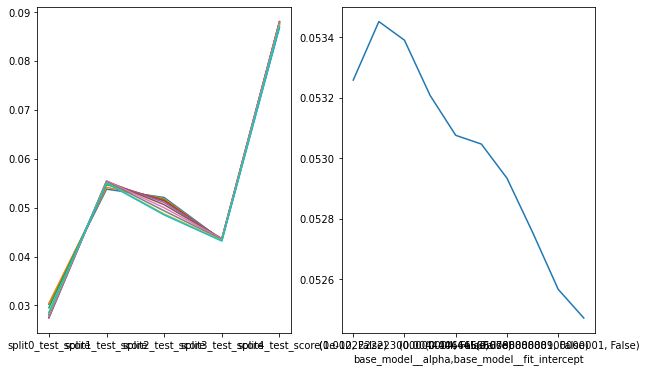

In [39]:
grid = {"base_model__alpha": np.linspace(1e-10, 1e-2, 10), "base_model__fit_intercept": [False,]}
df_lasso_pool = run_cv(Lasso(), grid, True)
scores = plot_cv_scores(df_lasso_pool)
scores.mean().idxmax() # prado

(0.01, False)

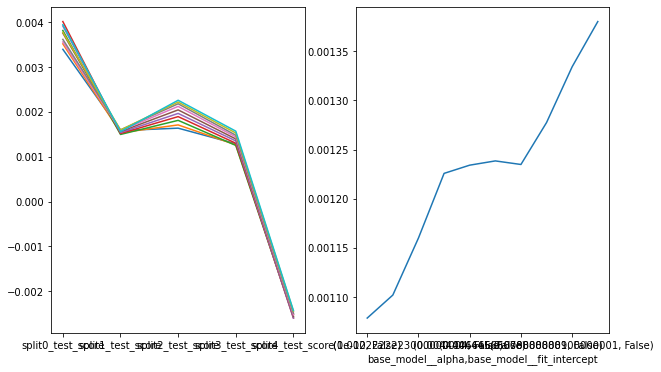

In [40]:
grid = {"base_model__alpha": np.linspace(1e-10, 1e-2, 10), "base_model__fit_intercept": [False,]}
df_lasso_single = run_cv(Lasso(), grid, False)
scores = plot_cv_scores(df_lasso_single)
scores.mean().idxmax() # prado

(0.0044444445, False)

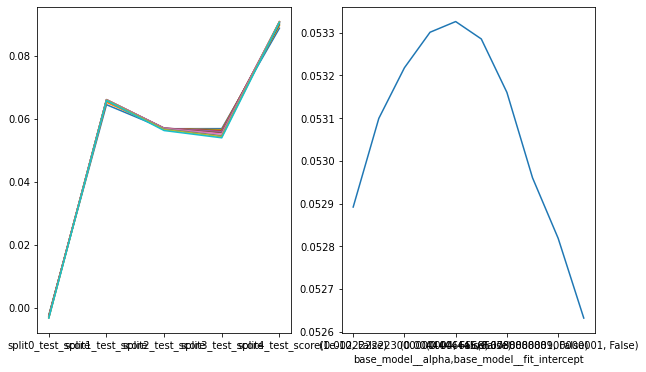

In [71]:
grid = {"base_model__alpha": np.linspace(1e-10, 1e-2, 10), "base_model__fit_intercept": [False,]}
df_lasso_pool = run_cv(Lasso(), grid, True)
scores = plot_cv_scores(df_lasso_pool)
scores.mean().idxmax() # prado

#### Single Asset
Note: The optimum parameter is different from the panel model. Expected since the models are constructed differently.

(0.0023, False)

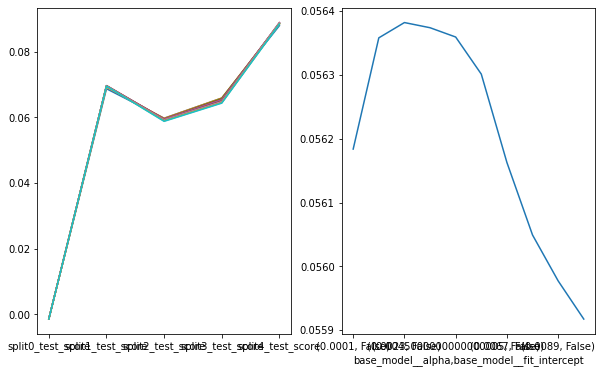

In [41]:
grid = {"base_model__alpha": np.linspace(1e-4, 1e-2, 10), "base_model__fit_intercept": [False,]}
df_lasso_single = run_cv(Lasso(), grid, False)
scores = plot_cv_scores(df_lasso_single)
scores.mean().idxmax() # prado

### LGBM Model
Use Huber loss to reduce the impact of outliers on training.


#### Single Asset
- The scores look *very* similar to the lasso model
  - They are slightly better, but the general shape is the same
  - Possibly expected from the 'No Free Lunch' theorem
    - (on average all models perform the same)

(3, 'gbdt', 0.01, 0.01, 200, 31, 'huber')

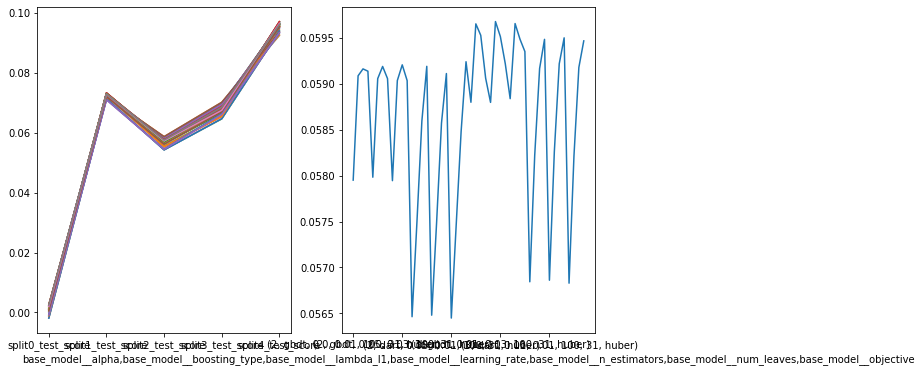

In [70]:
grid = {
    "base_model__learning_rate": np.arange(1, 5, 2)/100,
    "base_model__n_estimators": [100, 200],
    "base_model__num_leaves": [31,],
    "base_model__boosting_type": ["gbdt", "dart"],
    "base_model__lambda_l1": [0, 0.01, 0.05],
    "base_model__objective": ["huber",],
    "base_model__alpha": [2, 3],
    }
df_lgbm_single = run_cv(lightgbm.LGBMRegressor(), grid, False)
scores = plot_cv_scores(df_lgbm_single)
scores.mean().idxmax() # prado

#### Score Consistency
- There is a big difference between the median + mean scores
  - This is due to outlier scores (first + last folds)
  - To help fix this use more folds
    - Due to time + computational constraints we stick with 5 folds
- We select different models if we instead look at the median
- Remember: We prefer simple models to help avoid overfitting
  - For two models with similar scores, we prefer the one with more consistent scores
  - Here, pick (3, 'gbdt', 0.05, 0.03, 200, 31, 'huber') since the higher regularisation doesn't have much of an impact on the average score

In [68]:
scores.median().sort_values(ascending=False).head()

base_model__alpha  base_model__boosting_type  base_model__lambda_l1  base_model__learning_rate  base_model__n_estimators  base_model__num_leaves  base_model__objective
3                  gbdt                       0.05                   0.03                       200                       31                      huber                    0.070118
                                              0.01                   0.03                       200                       31                      huber                    0.070110
                                                                                                100                       31                      huber                    0.069818
                                              0.00                   0.03                       200                       31                      huber                    0.069744
                                                                                                100             

In [69]:
scores.mean().sort_values(ascending=False).head()

base_model__alpha  base_model__boosting_type  base_model__lambda_l1  base_model__learning_rate  base_model__n_estimators  base_model__num_leaves  base_model__objective
3                  gbdt                       0.01                   0.01                       200                       31                      huber                    0.059679
                                              0.05                   0.01                       200                       31                      huber                    0.059657
                                              0.00                   0.01                       200                       31                      huber                    0.059654
                                                                     0.03                       100                       31                      huber                    0.059529
                                              0.01                   0.03                       100             

#### Pool
Pick (3, 'gbdt', 0.05, 0.03, 200, 31, 'huber')

[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM]

(3, 'gbdt', 0.05, 0.03, 200, 31, 'huber')

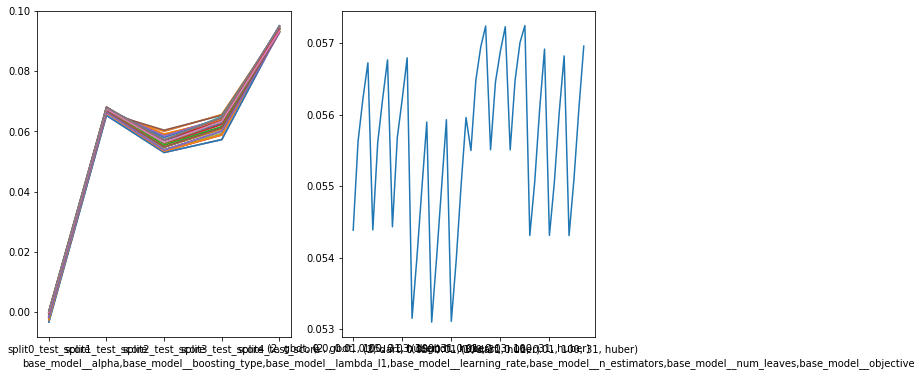

In [42]:
grid = { 
    "base_model__learning_rate": np.arange(1, 5, 2)/100,
    "base_model__n_estimators": [100, 200],
    "base_model__num_leaves": [31,],
    "base_model__boosting_type": ["gbdt", "dart"],
    "base_model__lambda_l1": [0, 0.01, 0.05],
    "base_model__objective": ["huber",],
    "base_model__alpha": [2, 3],
    }
df_lgbm_pool = run_cv(lightgbm.LGBMRegressor(), grid, True)
scores = plot_cv_scores(df_lgbm_pool)
scores.mean().idxmax() # prado

### Neural Net Model
Test different NN architectures for prediction.

#### Pool
Pick (1000, ((dense, 8), (dense, 4), (dense, 4)), 5)

3004/3004 [==============================] - 3s 871us/step - loss: 1.1175
Epoch 1/5
2973/2973 [==============================] - 2s 638us/step - loss: 1.1810
Epoch 2/5
2973/2973 [==============================] - 2s 653us/step - loss: 1.1752
Epoch 3/5
2973/2973 [==============================] - 2s 656us/step - loss: 1.1750
Epoch 4/5
2973/2973 [==============================] - 2s 642us/step - loss: 1.1746
Epoch 5/5
2973/2973 [==============================] - 2s 644us/step - loss: 1.1743
Epoch 1/5
2973/2973 [==============================] - 2s 656us/step - loss: 1.1904
Epoch 2/5
2973/2973 [==============================] - 2s 635us/step - loss: 1.1645
Epoch 3/5
2973/2973 [==============================] - 2s 650us/step - loss: 1.1644
Epoch 4/5
2973/2973 [==============================] - 2s 652us/step - loss: 1.1641
Epoch 5/5
2973/2973 [==============================] - 2s 659us/step - loss: 1.1638
Epoch 1/5
2973/2973 [==============================] - 2s 634us/step - loss: 1.1713
Ep

(1000, 5, (('dense', 8), ('dense', 4), ('dense', 4)))

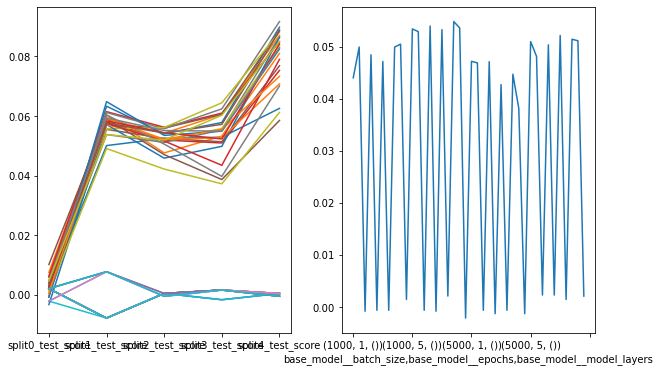

In [114]:
nn_model = KerasRegressor(build_fn=create_nn_model)

grid = {
    "base_model__model_layers": [
        tuple(),
        (("dense", 4),),
        (("dense", 4), ("dropout", 0.005)),
        (("dense", 8),),
        (("dense", 8), ("dropout", 0.005)),
        (("dense", 8), ("dense", 4)),
        (("dense", 8), ("dropout", 0.005), ("dense", 4)),
        (("dense", 8), ("dense", 4), ("dense", 4)),
        (("dense", 8), ("dense", 8), ("dense", 4)),
        (("dense", 8), ("dropout", 0.005), ("dense", 8), ("dropout", 0.005), ("dense", 4)),
    ],
    "base_model__batch_size": [1000, 5000],
    "base_model__epochs": [1, 5],
    }
# grid = {"base_model__build_fn": grid}

df_nn_pool = run_cv(nn_model, grid, True)
scores = plot_cv_scores(df_nn_pool)
scores.mean().idxmax() # prado

#### Single

1001/1001 [==============================] - 1s 872us/step - loss: 1.1313
Epoch 1/5
992/992 [==============================] - 1s 667us/step - loss: 1.1606
Epoch 2/5
992/992 [==============================] - 1s 666us/step - loss: 1.1603
Epoch 3/5
992/992 [==============================] - 1s 657us/step - loss: 1.1602
Epoch 4/5
992/992 [==============================] - 1s 659us/step - loss: 1.1600
Epoch 5/5
992/992 [==============================] - 1s 680us/step - loss: 1.1599
Epoch 1/5
991/991 [==============================] - 1s 703us/step - loss: 1.1190
Epoch 2/5
991/991 [==============================] - 1s 647us/step - loss: 1.1170
Epoch 3/5
991/991 [==============================] - 1s 670us/step - loss: 1.1168
Epoch 4/5
991/991 [==============================] - 1s 653us/step - loss: 1.1167
Epoch 5/5
991/991 [==============================] - 1s 662us/step - loss: 1.1167
Epoch 1/5
991/991 [==============================] - 1s 642us/step - loss: 1.2756
Epoch 2/5
991/991 [=====

(1000, 5, (('dense', 8), ('dense', 4), ('dense', 4)))

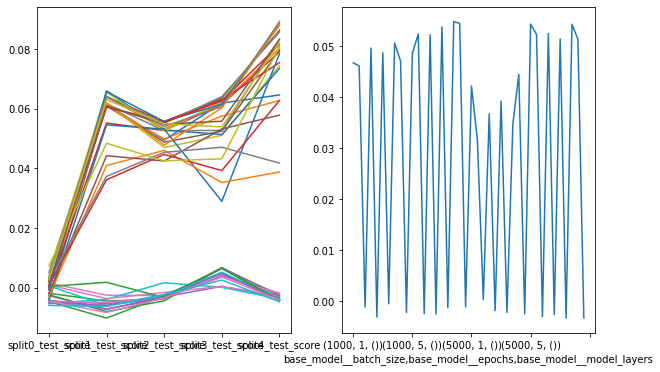

In [162]:
nn_model = KerasRegressor(build_fn=create_nn_model)

grid = {
    "base_model__model_layers": [
        tuple(),
        (("dense", 4),),
        (("dense", 4), ("dropout", 0.005)),
        (("dense", 8),),
        (("dense", 8), ("dropout", 0.005)),
        (("dense", 8), ("dense", 4)),
        (("dense", 8), ("dropout", 0.005), ("dense", 4)),
        (("dense", 8), ("dense", 4), ("dense", 4)),
        (("dense", 8), ("dense", 8), ("dense", 4)),
        (("dense", 8), ("dropout", 0.005), ("dense", 8), ("dropout", 0.005), ("dense", 4)),
    ],
    "base_model__batch_size": [1000, 5000],
    "base_model__epochs": [1, 5],
    }
# grid = {"base_model__build_fn": grid}

df_nn_single = run_cv(nn_model, grid, False)
scores = plot_cv_scores(df_nn_single)
scores.mean().idxmax() # prado

## Pool All Assets
Earlier we also considered a pooled model across all assets. Let's tune Lasso + LGBM + NN models for these too.

For simplicity, search a reduced set of parameters for these.

In [ ]:
all_assetids = ad.index.values
train_stacked_ = train_stacked.dropna()

cv_timestamps_all = train_stacked_.index.get_level_values(0).unique()
cv_splits_all = cv_split(cv_timestamps_all, n_splits=5, overlap=16, embargo=7*24*60) # 7 days embargo
cv_indices_all = timestamp_folds_to_indices(cv_splits_all, train_stacked_.index.get_level_values(0))

### Lasso

(0.0067, False)

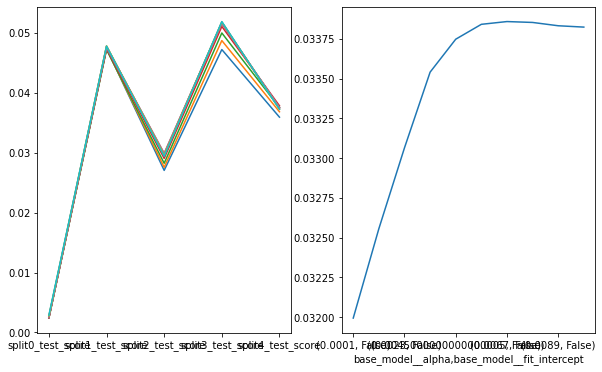

In [172]:
grid = grid = {"base_model__alpha": np.linspace(1e-4, 1e-2, 10), "base_model__fit_intercept": [False,]}
pool_all_lasso = run_cv(Lasso(), grid, pool=True, cv_inds=cv_indices_all, cluster=all_assetids, stacked_data_=train_stacked_)
scores = plot_cv_scores(pool_all_lasso)
scores.mean().idxmax() # prado

### LGBM

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0

(3, 0.01, 0.02, 400, 'huber')

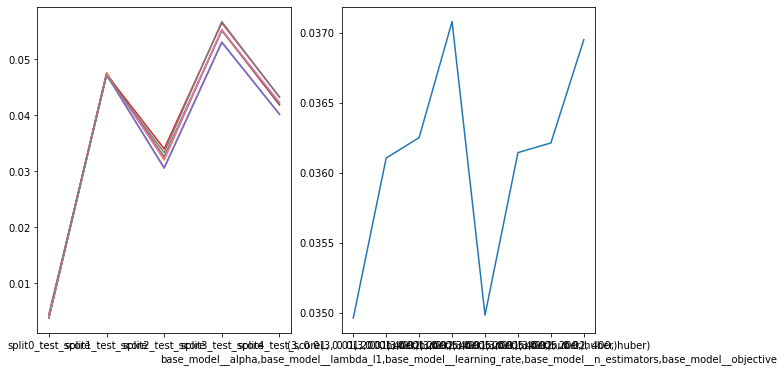

In [173]:
grid = { 
    "base_model__learning_rate": [0.01, 0.02],
    "base_model__n_estimators": [200, 400],
    "base_model__lambda_l1": [0.01, 0.05],
    "base_model__objective": ["huber",],
    "base_model__alpha": [3],
    } # params explored reflect more available data (more complexity)
pool_all_lgbm = run_cv(lightgbm.LGBMRegressor(), grid, pool=True, cv_inds=cv_indices_all, cluster=all_assetids, stacked_data_=train_stacked_)
scores = plot_cv_scores(pool_all_lgbm)
scores.mean().idxmax() # prado

### NN

Epoch 1/5
11621/11621 [==============================] - 9s 694us/step - loss: 1.5630
Epoch 2/5
11621/11621 [==============================] - 8s 687us/step - loss: 1.5604
Epoch 3/5
11621/11621 [==============================] - 8s 689us/step - loss: 1.5604
Epoch 4/5
11621/11621 [==============================] - 8s 695us/step - loss: 1.5603
Epoch 5/5
11621/11621 [==============================] - 8s 693us/step - loss: 1.5601
Epoch 1/5
11008/11008 [==============================] - 8s 699us/step - loss: 1.6304
Epoch 2/5
11008/11008 [==============================] - 8s 699us/step - loss: 1.6301
Epoch 3/5
11008/11008 [==============================] - 8s 711us/step - loss: 1.6300
Epoch 4/5
11008/11008 [==============================] - 8s 707us/step - loss: 1.6298
Epoch 5/5
11008/11008 [==============================] - 8s 704us/step - loss: 1.6298
Epoch 1/5
10791/10791 [==============================] - 8s 694us/step - loss: 1.7067
Epoch 2/5
10791/10791 [==============================]

2021-12-19 01:21:09.433713: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 557461760 exceeds 10% of free system memory.


Epoch 1/10
13937/13937 [==============================] - 11s 758us/step - loss: 1.6133
Epoch 2/10
13937/13937 [==============================] - 11s 758us/step - loss: 1.6117
Epoch 3/10
13937/13937 [==============================] - 10s 748us/step - loss: 1.6115
Epoch 4/10
13937/13937 [==============================] - 10s 752us/step - loss: 1.6114
Epoch 5/10
13937/13937 [==============================] - 11s 763us/step - loss: 1.6113
Epoch 6/10
13937/13937 [==============================] - 11s 761us/step - loss: 1.6112
Epoch 7/10
13937/13937 [==============================] - 11s 760us/step - loss: 1.6112
Epoch 8/10
13937/13937 [==============================] - 11s 764us/step - loss: 1.6111
Epoch 9/10
13937/13937 [==============================] - 10s 749us/step - loss: 1.6111
Epoch 10/10
13937/13937 [==============================] - 11s 767us/step - loss: 1.6111


(1000, 10, (('dense', 8), ('dense', 4)))

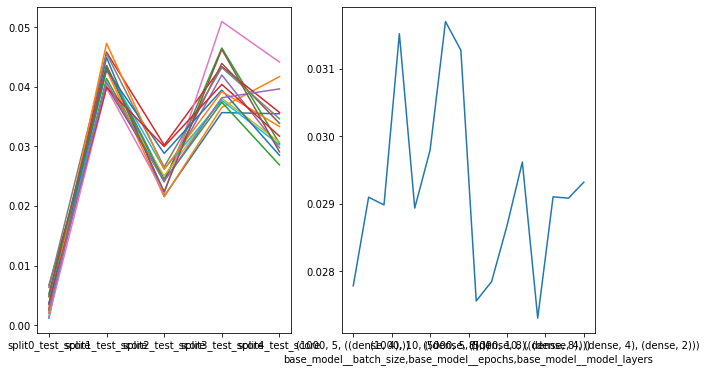

In [174]:
from keras.wrappers.scikit_learn import KerasRegressor
nn_model = KerasRegressor(build_fn=create_nn_model)

grid = {
    "base_model__model_layers": [
        (("dense", 4),),
        (("dense", 8),),
        (("dense", 8), ("dense", 4)),
        (("dense", 8), ("dense", 4), ("dense", 2)),
    ], # ignore dropout + test subset for simplicity
    "base_model__batch_size": [1000, 5000],
    "base_model__epochs": [5, 10],
    } # parameters chosen as above

pool_all_nn = run_cv(nn_model, grid, pool=True, cv_inds=cv_indices_all, cluster=all_assetids, stacked_data_=train_stacked_)
scores = plot_cv_scores(pool_all_nn)
scores.mean().idxmax() # prado

## Model Allocations
... for simplicity use the same hyperparameters for single asset + pool models


Now we've decided on the specific models + parameters we're using, all that is remaining is to assign weights to each model:
- How much weight to assign to the Lasso/LGBM/NN models
- How much weight to assign to the pool/single models

The procedure will be:
- Split the train set into 80:20 train_1, test_1
  - Note: test_1 is contaminated since we used it for parameter optimisation, but this should be acceptable for deciding an initial allocation
  - We will check this on the validation set which we haven't used yet
- Train all pool/single + Lasso/LGBM/NN models on train_1
- Compute predictions on test_1
- Calculate a rolling correlation between the predictions and targets
- Allocate weights to models to optimise for the median rolling correlation
  - This is to help avoid overfitting: if the average correlation is high then we can be confident the result generalises

In [8]:
from keras.wrappers.scikit_learn import KerasRegressor
nn_model = KerasRegressor(build_fn=create_nn_model)

all_assetids = list(range(14))

pool_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.0044444445, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.03, "lambda_l1": 0.05, "n_estimators": 200, "alpha": 3, "objective": "huber"}
    },
    "NN": {
        "model": KerasRegressor(create_nn_model),
        "params": {"epochs": 5, "batch_size": 1000, "model_layers": (("dense", 8), ("dense", 4), ("dense", 4))},
    },
}

single_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.0023, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.01, "lambda_l1": 0.01, "n_estimators": 200, "alpha": 3, "objective": "huber"}
    },
    "NN": {
        "model": KerasRegressor(create_nn_model),
        "params": {"epochs": 5, "batch_size": 1000, "model_layers": (("dense", 8), ("dense", 4), ("dense", 4))},
    },
}

all_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.0067, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.02, "lambda_l1": 0.01, "n_estimators": 400, "alpha": 3, "objective": "huber"}
    },
    "NN": {
        "model": KerasRegressor(create_nn_model),
        "params": {"epochs": 10, "batch_size": 1000, "model_layers": (("dense", 8), ("dense", 4))},
    },
}

param_dict = {
    "pool": {
        "params": pool_params,
        "clusters": clusters,
    },
    "single": {
        "params": single_params,
        "clusters": {k: [k] for k in all_assetids}, # FIXME: should use `single_asset_regressor`
    },
    "pool_all": {
        "params": all_params,
        "clusters": {-1: all_assetids},
    },
}

In [9]:
def fit_on_params(params, clusters, train):
    """Take a dict of parameters specifying models + parameters for fitting
    and a dict of clusters to pass to PoolRegressor for fitting models.
    """
    models = {}
    for model_name, config_dict in params.items():
        model = config_dict["model"].set_params(**config_dict["params"])
        pool_model = PoolRegressor(base_model=model, clusters=clusters)
        models[model_name] = pool_model.fit(train)
    return models

In [12]:
train_stacked_ = train_stacked.dropna()
(train_2, test_2), = ts_split(train_ind, 1, 0.2)

train_2_stacked = train_stacked_.loc[train_2]
test_2_stacked = train_stacked_.loc[test_2]

### Baseline on Pool models
Let's do a simple allocation to see if our approach will work.

We do a `1/N` (equal weighted mean) allocation to lasso + LGBM + NN pool models. This is not optimised, so any positive result here would be a good indication an actual optimisation will work.

In [194]:
paramed_pool = fit_on_params(param_dict["pool"]["params"], param_dict["pool"]["clusters"], train_2_stacked) # fit pool models
paramed_pool_preds = {k: m.predict(test_2_stacked) for k, m in paramed_pool.items()} # get predictions

avg_preds = sum(paramed_pool_preds.values()) / len(paramed_pool_preds) # equal weighted predictions across lasso + LGBM + NN
act = test_2_stacked.target.unstack() # actual targets
corrs__ = pd.DataFrame({k: v.corrwith(act) for k, v in {**paramed_pool_preds, "avg": avg_preds}.items()})

Epoch 1/5
1517/1517 [==============================] - 2s 873us/step - loss: 1.6040
Epoch 2/5
1517/1517 [==============================] - 1s 898us/step - loss: 1.5999
Epoch 3/5
1517/1517 [==============================] - 1s 871us/step - loss: 1.5997
Epoch 4/5
1517/1517 [==============================] - 1s 865us/step - loss: 1.5997
Epoch 5/5
1517/1517 [==============================] - 1s 884us/step - loss: 1.5996
Epoch 1/5
3561/3561 [==============================] - 4s 895us/step - loss: 1.9630
Epoch 2/5
3561/3561 [==============================] - 3s 879us/step - loss: 1.9616
Epoch 3/5
3561/3561 [==============================] - 3s 874us/step - loss: 1.9614
Epoch 4/5
3561/3561 [==============================] - 3s 894us/step - loss: 1.9613
Epoch 5/5
3561/3561 [==============================] - 3s 898us/step - loss: 1.9612
Epoch 1/5
2891/2891 [==============================] - 3s 887us/step - loss: 1.4394
Epoch 2/5
2891/2891 [==============================] - 3s 888us/step - loss:

lasso   -0.004482
LGBM    -0.001086
NN      -0.007170
dtype: float64

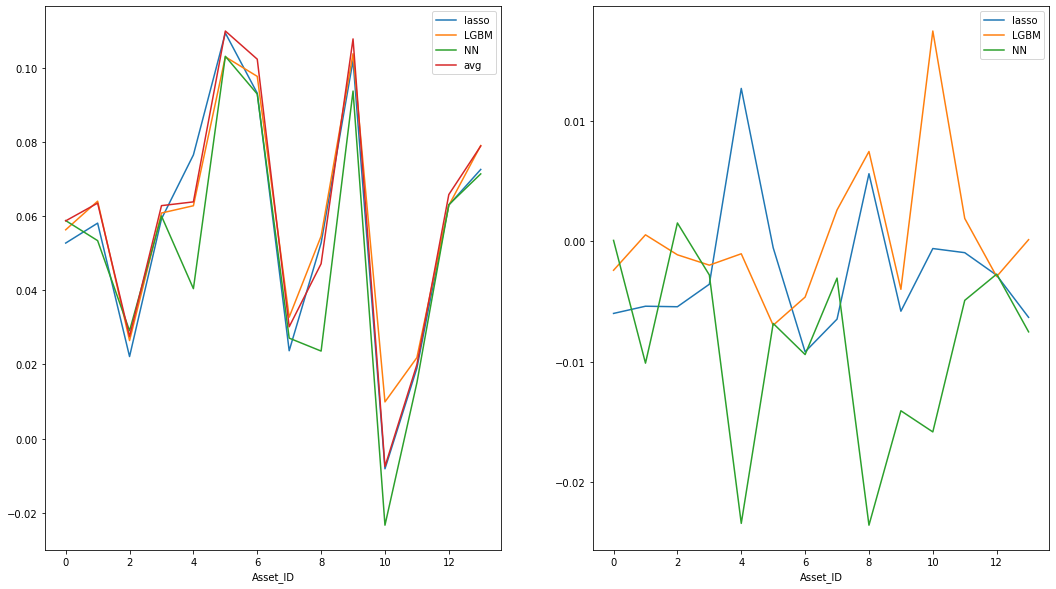

In [249]:
rel_corrs = corrs__.sub(corrs__["avg"], axis=0).drop(columns="avg")

fig, ax = plt.subplots(1, 2, figsize=(18,10))
corrs__.plot(ax=ax[0])
rel_corrs.plot(ax=ax[1])
rel_corrs.median()

... on average the combined prediction is better than the individual predictions, so this is an indication our optimisation is sensible.

In [259]:
all_models = {k: fit_on_params(pd["params"], pd["clusters"], train_2_stacked) for k, pd in param_dict.items()} # fit all models

Epoch 1/5
1517/1517 [==============================] - 2s 885us/step - loss: 1.6054
Epoch 2/5
1517/1517 [==============================] - 1s 908us/step - loss: 1.6001
Epoch 3/5
1517/1517 [==============================] - 1s 911us/step - loss: 1.5998
Epoch 4/5
1517/1517 [==============================] - 1s 911us/step - loss: 1.5996
Epoch 5/5
1517/1517 [==============================] - 1s 913us/step - loss: 1.5996
Epoch 1/5
3561/3561 [==============================] - 3s 883us/step - loss: 1.9624
Epoch 2/5
3561/3561 [==============================] - 3s 887us/step - loss: 1.9617
Epoch 3/5
3561/3561 [==============================] - 3s 906us/step - loss: 1.9614
Epoch 4/5
3561/3561 [==============================] - 3s 888us/step - loss: 1.9613
Epoch 5/5
3561/3561 [==============================] - 3s 890us/step - loss: 1.9611
Epoch 1/5
2891/2891 [==============================] - 3s 901us/step - loss: 1.4416
Epoch 2/5
2891/2891 [==============================] - 3s 890us/step - loss:

### Fitting all the models
Let's now fit all 9 PoolRegressor models and find an optimal combination scheme.

In [13]:
all_models = {k: fit_on_params(pd["params"], pd["clusters"], train_2_stacked) for k, pd in param_dict.items()} # fit all models
all_models_ = {
    f"{setup}_{model_type}": model
    for setup, model_dict in all_models.items()
    for model_type, model in model_dict.items()
}
all_preds = {k: model.predict(test_2_stacked) for k, model in all_models_.items()}

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

Epoch 1/5
1517/1517 [==============================] - 3s 2ms/step - loss: 1.6033
Epoch 2/5
1517/1517 [==============================] - 3s 2ms/step - loss: 1.5996
Epoch 3/5
1517/1517 [==============================] - 3s 2ms/step - loss: 1.5995
Epoch 4/5
1517/1517 [==============================] - 3s 2ms/step - loss: 1.5995
Epoch 5/5
1517/1517 [==============================] - 3s 2ms/step - loss: 1.5994
Epoch 1/5
3561/3561 [==============================] - 6s 2ms/step - loss: 1.9702
Epoch 2/5
3561/3561 [==============================] - 6s 2ms/step - loss: 1.9618
Epoch 3/5
3561/3561 [==============================] - 6s 2ms/step - loss: 1.9616
Epoch 4/5
3561/3561 [==============================] - 6s 2ms/step - loss: 1.9614
Epoch 5/5
3561/3561 [==============================] - 6s 2ms/step - loss: 1.9613
Epoch 1/5
2891/2891 [==============================] - 5s 2ms/step - loss: 1.4395
Epoch 2/5
2891/2891 [==============================] - 4s 1ms/step - loss: 1.4390
Epoch 3/5
2891/2

In [14]:
def avg_preds(preds, model_weights):
    """Calculate a weighted average of an iterable of predictions using the given weights"""
    assert len(preds) == len(model_weights)
    return sum(p * w for p, w in zip(preds, model_weights)) / sum(model_weights)

def roll_corr(preds, act, asset_weights, roll_window):
    """Calculate the asset_weight weighted median correlation between the predictions and
    actual target.
    
    Note: this (intentionally) isn't the same as the final evaluation target. We optimise
    for consistency over all predictions (median rolling corr) rather than the final metric
    (a single number).
    """
    roll_corrs = preds.rolling(roll_window, min_periods=roll_window // 100).corr(act).median().fillna(0) # FIXME: sometimes this can be nan -> data preparation issues?
    return np.sum(roll_corrs * asset_weights) / np.sum(asset_weights)

In [296]:
# weighted_correlation(all_preds[list(all_preds)[0]].stack(), act.stack(), )

0.04876455054970501

#### Performance across models + assets
The per-asset performance is similar for most models (the biggest exception being asset 10 - this has a small weight however so let's not investigate to save time for more important things).

Let's see how much this can be improved (in sample) by averaging these predictions across models. We then confirm the result on the validation set.

<AxesSubplot:xlabel='Asset_ID'>

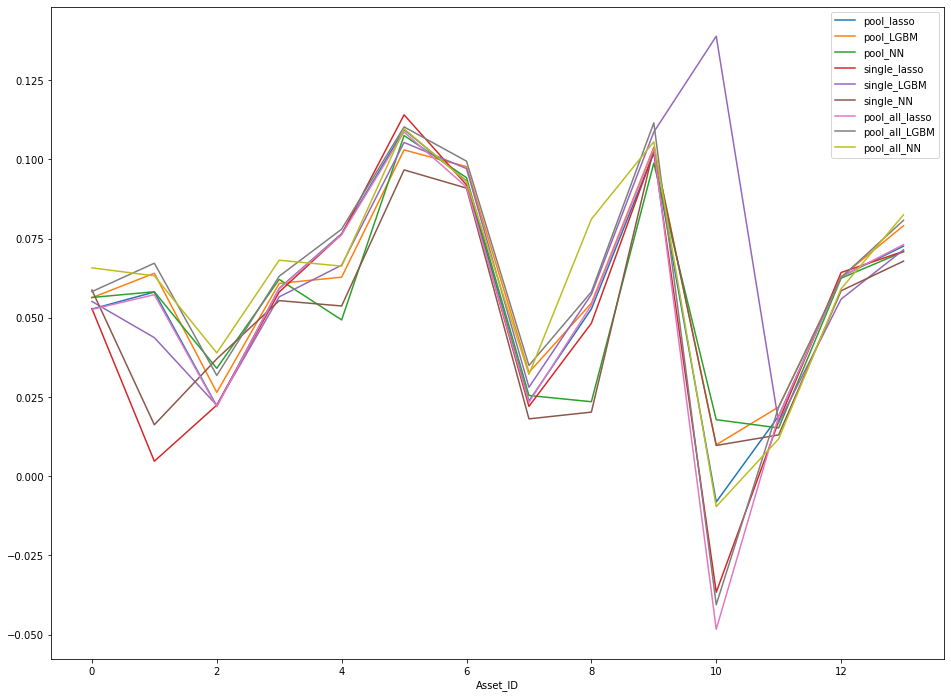

In [28]:
model_asset_corrs = pd.DataFrame({k: v.corrwith(act) for k, v in all_preds.items()})
model_asset_corrs.plot(figsize=(16,12))

#### Finding the 'optimal' allocation
The improvement over the baseline is negligible, perhaps expected since all predictions are likely to be highly correlated.

Some observations:
- The NN model is given almost 0 weight. This could be due to:
  - Having worse performance than the other models
  - Substitution effects
- ... in any case let's drop this model since it doesn't add value.
  - ... also suggests our earlier result of NN outperforming LGBM being a fluke. We're testing many things so not completely unexpected.
- single + all models are given similar weights in total (roughly 0.4), pool slightly less (roughly 0.2)
  - All are non-trivial so suggests each approach is adding value
  - `Cluster pooling` seems worse since given a smaller weight
    - Difficult to set expectations for value-add of `cluster pooling` vs `all pooling` models since each have their trade-offs
      - `cluster pooling` takes advantage of the correlation structure of the assets
      - `all pooling` has access to more data
- Lasso is generally given more weight than LGBM
  - LGBM models are more complex, but easier to overfit (this problem could be mitigated with better CV + parameter tuning)
  - The feature set is relatively small, so LGBM could just be worse due to lack of feaatures to work with

In [66]:
all_preds_list = list(all_preds.values())
neg_wt_corr = lambda w: -roll_corr(avg_preds(all_preds_list, w), act, weights, 1000)
n_models = len(all_preds)
-neg_wt_corr([1 for _ in range(9)])

0.1019160463624608

In [75]:
from scipy.optimize import minimize, LinearConstraint
bounds = [(0, 1) for _ in range(n_models)]
constraints = LinearConstraint(np.ones(n_models), 1, 1) # sum of weights = 1
optim_model_wts = minimize(neg_wt_corr, np.ones(n_models)/n_models, bounds=bounds, constraints=constraints)
-neg_wt_corr(optim_model_wts.x) # 2% improvement over the above

0.10402422236608197

In [77]:
optim_wt_dict = dict(zip(all_preds, optim_model_wts.x))
optim_wt_dict

{'pool_lasso': 0.1849257667761352,
 'pool_LGBM': 0.05624889334760342,
 'pool_NN': 2.1461513304671826e-16,
 'single_lasso': 0.2108317665983181,
 'single_LGBM': 0.16298085219614764,
 'single_NN': 1.5625726967696262e-16,
 'pool_all_lasso': 0.18284479169146128,
 'pool_all_LGBM': 0.20206164888310554,
 'pool_all_NN': 0.00010628050741565481}

In [89]:
equal_wt_preds_stacked = avg_preds(all_preds_list, np.ones(n_models)).stack()
optim_wt_preds_stacked = avg_preds(all_preds_list, optim_model_wts.x).stack()
asset_weights_stacked = test_2_stacked.target_weight
act_stacked = act.stack()

#### The Final Metric
Let's look at the improvement (if any) on the final metric of the optimal allocation vs the `1/N` allocation.

There is a *big* improvement compared to the metric we were optimising for before! Because of this discrepancy I doubt we were optimising for the correct objective. Let's ignore and revisit if time allows.

(We also do better than each individual model, this is an in-sample observation so not surprising - even though we were optimising for a different (but similar) objective).

In [110]:
pd.Series({k: weighted_correlation(p.stack(), act_stacked, asset_weights_stacked) for k, p in all_preds.items()}).sort_values() # final metric for all individual models

single_NN         0.003907
pool_NN           0.044781
pool_all_NN       0.046887
pool_all_lasso    0.047502
pool_lasso        0.048765
pool_LGBM         0.051421
pool_all_LGBM     0.053474
single_LGBM       0.054843
single_lasso      0.055512
dtype: float64

In [93]:
weighted_correlation(equal_wt_preds_stacked, act_stacked, asset_weights_stacked) # 1/N allocation

0.02575526878007895

In [111]:
weighted_correlation(optim_wt_preds_stacked, act_stacked, asset_weights_stacked) # optimal allocation

0.05741472412197852

#### Final Allocations
Let's simplify the allocations and (finally!) train on all training data and test on the validation set.

In [6]:
from sklearn.ensemble import VotingRegressor

final_allocations = {
    'pool_lasso': 0.2,
    'pool_LGBM': 0.05,
    'single_lasso': 0.2,
    'single_LGBM': 0.15,
    'pool_all_lasso': 0.2,
    'pool_all_LGBM': 0.2,
}

all_assetids = list(range(14))

pool_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.0044444445, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.03, "lambda_l1": 0.05, "n_estimators": 200, "alpha": 3, "objective": "huber"}
    },
}

single_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.0023, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.01, "lambda_l1": 0.01, "n_estimators": 200, "alpha": 3, "objective": "huber"}
    },
}

all_params = {
    "lasso": {
        "model": Lasso(),
        "params": {"alpha": 0.0067, "fit_intercept": False},
    },
    "LGBM": {
        "model": lightgbm.LGBMRegressor(),
        "params": {"learning_rate": 0.02, "lambda_l1": 0.01, "n_estimators": 400, "alpha": 3, "objective": "huber"}
    },
}

param_dict = {
    "pool": {
        "params": pool_params,
        "clusters": clusters,
    },
    "single": {
        "params": single_params,
        "clusters": {k: [k] for k in all_assetids}, # FIXME: should use `single_asset_regressor`
    },
    "pool_all": {
        "params": all_params,
        "clusters": {-1: all_assetids},
    },
}


all_models = {
    f"{setup}_{model_type}": PoolRegressor(model["model"].set_params(**model["params"]), clusters=model_dict["clusters"])
    for setup, model_dict in param_dict.items()
    for model_type, model in model_dict["params"].items()
}
models_list = [(k, model) for k, model in all_models.items()]
model_weight_list = [final_allocations[k] for k in all_models] # ensure in same order

voting_model = VotingRegressor(estimators=models_list, weights=model_weight_list)

In [7]:
train_stacked_ = train_stacked.dropna()
voting_model.fit(train_stacked_, np.empty_like(train_stacked_.iloc[:, 0]))

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05


VotingRegressor(estimators=[('pool_lasso',
                             PoolRegressor(base_model=Lasso(alpha=0.0044444445,
                                                            fit_intercept=False),
                                           clusters={0: (4, 8, 10, 11),
                                                     2: (0, 3, 12, 7),
                                                     3: (2, 5, 13),
                                                     4: (1, 6, 9)})),
                            ('pool_LGBM',
                             PoolRegressor(base_model=LGBMRegressor(alpha=3,
                                                                    lambda_l1=0.05,
                                                                    learning_rate=0.03,
                                                                    n_estimators=200,
                                                                    objective='huber'),
                                           cluste

In [8]:
valid_stacked = data.loc[validation_ind].stack().join(target_weights, on="Asset_ID").dropna() # FIXME: this should be done in the library
score_pool_model(voting_model, valid_stacked)

0.031410638926440186

... less than the 0.0574... score we had previously

I suspect we probably overfit in the model allocation stage since:
- This 0.03... score is more comparable to the naive `1/N` allocation score
- The CV scores are heavily skewed by the last fold

Let's check the scores from the individual models. We see that only the pool_all models performed well - this is unexpected since all models did better in testing, so this suggests we possibly overfit in the model selection stage.

In [21]:
individual_corrs = [score_pool_model(estim, valid_stacked) for estim in voting_model.estimators_]
individual_corrs = dict(zip([x[0] for x in voting_model.estimators], individual_corrs))
individual_corrs

{'pool_lasso': 0.0004918408752819247,
 'pool_LGBM': 0.0005893155090442618,
 'single_lasso': -0.0004391460106593198,
 'single_LGBM': -0.0009201714541597062,
 'pool_all_lasso': 0.04664486484109309,
 'pool_all_LGBM': 0.04847825052086145}

### Next Steps
At this point I would iterate on my results to fix some of the issues I've seen, especially for the hyperparameter tuning - this seems to have caused unacceptable overfitting in our results above.

Note: we still haven't seen the test set so we are free to continue iterating and testing on the validation set - and only looking at the test set after we've tested everything we want to test. To save time however, I will not iterate further.

Let's repeat the above but retrain on train + validation and test on the unseen test set:

In [22]:
full_train_stacked_ = pd.concat([train_stacked_, valid_stacked])

In [24]:
voting_model_ = VotingRegressor(estimators=models_list, weights=model_weight_list)
voting_model_.fit(full_train_stacked_, np.empty_like(full_train_stacked_.iloc[:, 0]))

[LightGBM] [Warning] lambda_l1 is set=0.05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05


VotingRegressor(estimators=[('pool_lasso',
                             PoolRegressor(base_model=Lasso(alpha=0.0044444445,
                                                            fit_intercept=False),
                                           clusters={0: (4, 8, 10, 11),
                                                     2: (0, 3, 12, 7),
                                                     3: (2, 5, 13),
                                                     4: (1, 6, 9)})),
                            ('pool_LGBM',
                             PoolRegressor(base_model=LGBMRegressor(alpha=3,
                                                                    lambda_l1=0.05,
                                                                    learning_rate=0.03,
                                                                    n_estimators=200,
                                                                    objective='huber'),
                                           cluste

In [30]:
test_stacked = data.loc[test_ind].stack().join(target_weights, on="Asset_ID").dropna() # FIXME: this should be done in the library

In [31]:
score_pool_model(voting_model_, test_stacked)

0.023126013994638466

In [32]:
individual_corrs_ = [score_pool_model(estim, test_stacked) for estim in voting_model_.estimators_]
individual_corrs_ = dict(zip([x[0] for x in voting_model_.estimators], individual_corrs_))
individual_corrs_

{'pool_lasso': -0.0009836098630504554,
 'pool_LGBM': -0.0006770659670428005,
 'single_lasso': -0.0009518660623553522,
 'single_LGBM': -0.0012145726029110725,
 'pool_all_lasso': 0.026858589894538633,
 'pool_all_LGBM': 0.03986975038903853}

In [33]:
individual_corrs_ = [score_pool_model(estim, full_train_stacked_) for estim in voting_model_.estimators_]
individual_corrs_ = dict(zip([x[0] for x in voting_model_.estimators], individual_corrs_))
individual_corrs_

{'pool_lasso': -0.00013054360235740986,
 'pool_LGBM': 0.0008993369381662202,
 'single_lasso': 0.00013163009433384766,
 'single_LGBM': 0.00012797837224127174,
 'pool_all_lasso': 0.02690799984545832,
 'pool_all_LGBM': 0.029168690157277088}